In [13]:
# Run only once (skip if already installed)
!pip install pandas scikit-learn matplotlib seaborn


In [ ]:
import pandas as pd

df = pd.read_csv("sales_data_sample.csv", encoding="unicode_escape")
df.head()


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


**Preprocessing (drop nulls + take numeric columns)**

In [15]:
# Select only numerical columns for clustering
df_numeric = df.select_dtypes(include=["int64", "float64"])

df_numeric = df_numeric.dropna()  # remove rows with missing values
df_numeric.head()


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP
0,10107,30,95.70,2,2871.00,1,2,2003,95
1,10121,34,81.35,5,2765.90,2,5,2003,95
2,10134,41,94.74,2,3884.34,3,7,2003,95
3,10145,45,83.26,6,3746.70,3,8,2003,95
4,10159,49,100.00,14,5205.27,4,10,2003,95


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

print("✅ Data normalized using StandardScaler")


✅ Data normalized using StandardScaler


**Elbow Method**

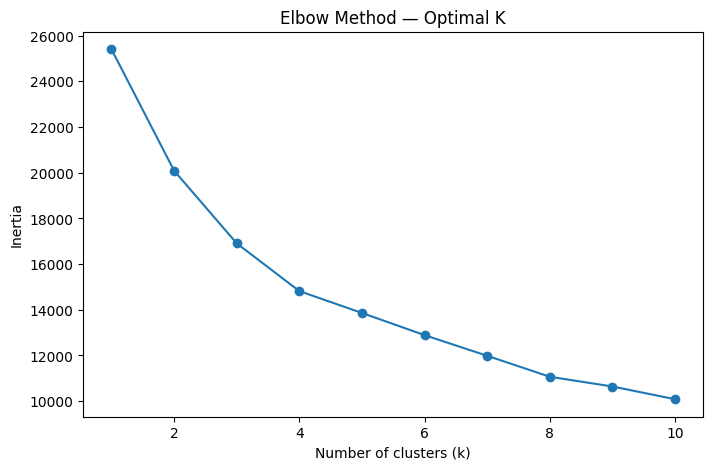

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method — Optimal K")
plt.show()


**Silhouette Method (automatically choose k)**

In [18]:
from sklearn.metrics import silhouette_score

best_k = 2
best_score = -1

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"K = {k} → Silhouette Score = {score:.4f}")

    if score > best_score:
        best_score = score
        best_k = k

print("\n✅ Best number of clusters based on Silhouette Score:", best_k)


K = 2 → Silhouette Score = 0.2169
K = 3 → Silhouette Score = 0.1960
K = 4 → Silhouette Score = 0.2059
K = 5 → Silhouette Score = 0.1848
K = 6 → Silhouette Score = 0.1753
K = 7 → Silhouette Score = 0.1832
K = 8 → Silhouette Score = 0.1835
K = 9 → Silhouette Score = 0.1784
K = 10 → Silhouette Score = 0.1842

✅ Best number of clusters based on Silhouette Score: 2


**Final KMeans model using best k**

In [19]:
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
df["Cluster"] = kmeans_final.fit_predict(X_scaled)

df[["SALES", "QUANTITYORDERED", "MSRP", "Cluster"]].head()


,SALES,QUANTITYORDERED,MSRP,Cluster
0,2871.00,30,95,0
1,2765.90,34,95,1
2,3884.34,41,95,1
3,3746.70,45,95,1
4,5205.27,49,95,1


**Visualization**

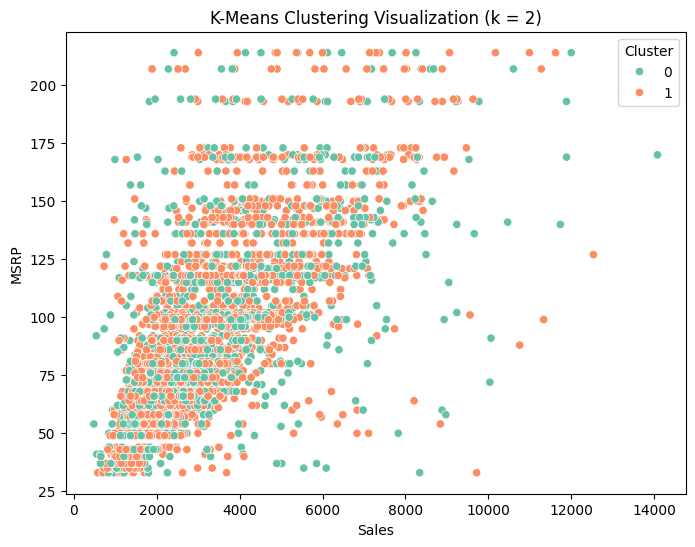

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_numeric["SALES"],
    y=df_numeric["MSRP"],
    hue=df["Cluster"],
    palette="Set2"
)
plt.title(f"K-Means Clustering Visualization (k = {best_k})")
plt.xlabel("Sales")
plt.ylabel("MSRP")
plt.show()


# **Hierarchical Clustering (Dendrogram)**

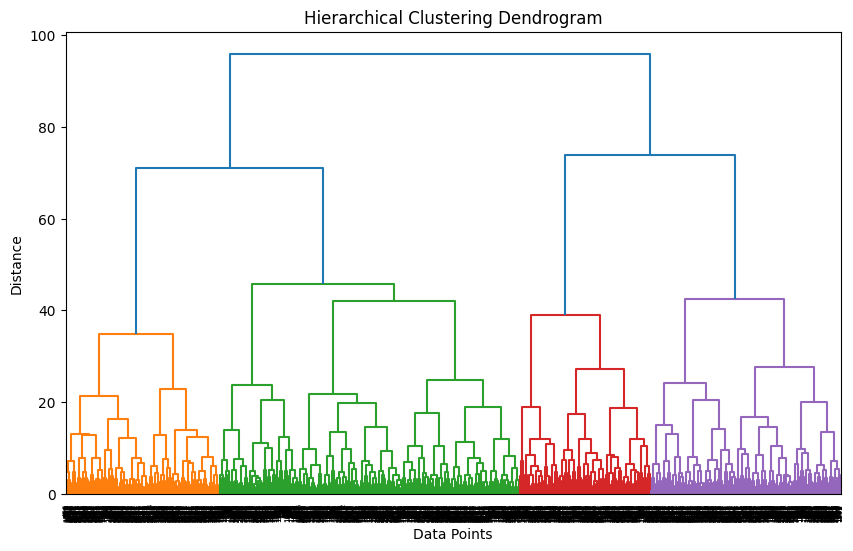

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Using Ward linkage (minimizes variance within each cluster)
plt.figure(figsize=(10, 6))
linkage_matrix = linkage(X_scaled, method='ward')

dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()


**Apply Agglomerative Clustering**

In [22]:
from sklearn.cluster import AgglomerativeClustering

# Set number of clusters based on dendrogram (example = 3 or same best_k)
hc = AgglomerativeClustering(n_clusters=best_k, linkage='ward')

df["HC_Cluster"] = hc.fit_predict(X_scaled)

df[["SALES", "QUANTITYORDERED", "PRICEEACH", "Cluster", "HC_Cluster"]].head()


,SALES,QUANTITYORDERED,PRICEEACH,Cluster,HC_Cluster
0,2871.00,30,95.70,0,0
1,2765.90,34,81.35,1,0
2,3884.34,41,94.74,1,1
3,3746.70,45,83.26,1,1
4,5205.27,49,100.00,1,1


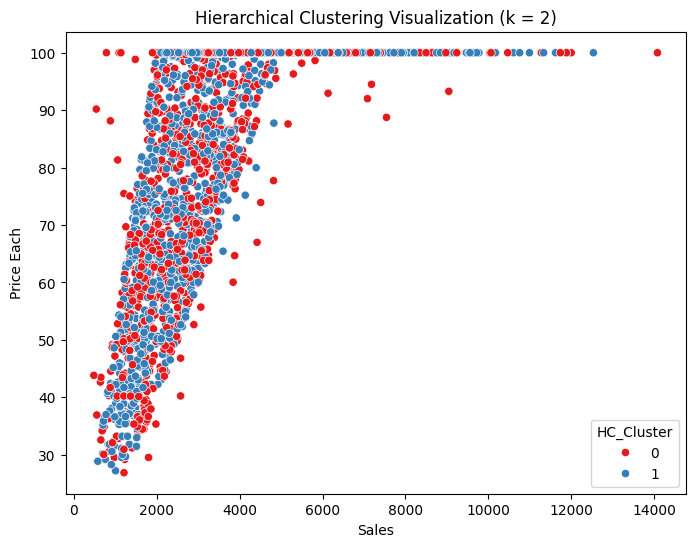

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_numeric['SALES'],
    y=df_numeric['PRICEEACH'],
    hue=df["HC_Cluster"],
    palette='Set1'
)
plt.title(f"Hierarchical Clustering Visualization (k = {best_k})")
plt.xlabel("Sales")
plt.ylabel("Price Each")
plt.show()
